# Example Log Analysis

In [1]:
import sys
 
sys.path.append("/home/vai_voxelsafety_com/voxel")

In [2]:
from core.structs.frame import Frame
LOG_PATH = "gs://voxel-temp/logs/vai/all/3/smooth/americold/modesto/e_dock_north/ch12/scenarios/PIGGYBACK/positive/41656/"
before_path = LOG_PATH + "AcausalNode.json"
after_path = LOG_PATH + "StateNode.json"

In [3]:
from core.infra.cloud.gcs_utils import read_from_gcs, does_gcs_blob_exists
import json
log_exists = does_gcs_blob_exists(before_path)
if log_exists:
    before_log = json.loads(read_from_gcs(before_path))
print(f"Before log exists: {log_exists}")

log_exists = does_gcs_blob_exists(after_path)
if log_exists:
    after_log = json.loads(read_from_gcs(after_path))
print(f"After log exists: {log_exists}")

Before log exists: True
After log exists: True


# Example analysis

This just shows a basic example of how you may analyze the frame. For this, we are choosing to print out the velocity of track 106.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
def get_boxes(log, des_actor_id=0, des_actor_category='PIT'):
    final_actor = None
    for l in log:
        actors = l['tracklets'].keys()
        for actor_id in actors:
            actor = l['tracklets'][actor_id]
            if actor['category'] == des_actor_category:
                print(actor_id)
                if actor['track_id'] == des_actor_id:
                    final_actor = l['tracklets'][actor_id]
    timestamps = np.array(final_actor['timestamps']) 
    xysr = np.array(final_actor['xysr_track']) 
    print(f"Timestamps: {timestamps.shape}, XYSR: {xysr.shape}")
    return timestamps, xysr

In [6]:
ACTOR_CATEGORY = "PIT"
ACTOR_ID = 104

ts_before, xysr_before = get_boxes(before_log, des_actor_id=ACTOR_ID, des_actor_category=ACTOR_CATEGORY)
ts_after, xysr_after = get_boxes(after_log, des_actor_id=ACTOR_ID, des_actor_category=ACTOR_CATEGORY)

105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104
105
104


In [7]:
def get_xysr_at_time_range(timestamp_range_ms, timestamps, xysr):

        # TODO(vai): Cleanup the indexing and ranges
        INTERPOLATION_WINDOW_SIZE_S = 3

        min_ind = self.get_closest_non_null_actor_at_time(
            timestamp_range_ms[0] - INTERPOLATION_WINDOW_SIZE_S * 1000
        )
        max_ind = self.get_closest_non_null_actor_at_time(
            timestamp_range_ms[-1] + INTERPOLATION_WINDOW_SIZE_S * 1000
        )

        timestamps = copy.deepcopy(timestamps[min_ind : max_ind + 1])
        xysr = copy.deepcopy(xysr_track[:, min_ind : max_ind + 1])

        if len(timestamps) <= 1:
            return np.array(xysr[:, 0]) if len(timestamps) > 0 else None

        # Set interpolation level
        interpolation_type = "nearest"
        if len(timestamps) == 2:
            interpolation_type = "linear"
        elif len(timestamps) == 3:
            interpolation_type = "quadratic"
        elif len(timestamps) >= 4:
            interpolation_type = "cubic"

        interpolation_type = "linear"

        x_array = xysr[0, :]
        y_array = xysr[1, :]
        s_array = xysr[2, :]
        r_array = xysr[3, :]

        x_interp = scipy.interpolate.interp1d(
            timestamps,
            x_array,
            kind=interpolation_type,
            bounds_error=False,
            fill_value=(x_array[0], x_array[-1]),
            assume_sorted=True,
        )
        y_interp = scipy.interpolate.interp1d(
            timestamps,
            y_array,
            kind=interpolation_type,
            bounds_error=False,
            fill_value=(y_array[0], y_array[-1]),
            assume_sorted=True,
        )
        s_interp = scipy.interpolate.interp1d(
            timestamps,
            s_array,
            kind=interpolation_type,
            bounds_error=False,
            fill_value=(s_array[0], s_array[-1]),
            assume_sorted=True,
        )
        r_interp = scipy.interpolate.interp1d(
            timestamps,
            r_array,
            kind=interpolation_type,
            bounds_error=False,
            fill_value=(r_array[0], r_array[-1]),
            assume_sorted=True,
        )

        # interpolate
        return np.vstack(
            [
                x_interp(timestamp_range_ms),
                y_interp(timestamp_range_ms),
                s_interp(timestamp_range_ms),
                r_interp(timestamp_range_ms),
            ]
        ).transpose()

In [8]:
GAUSSIAN_SMOOTHING_SIGMA_MS = 1
def smooth_tracklet(timestamps, xysr):

    # Get interpolated xysr trajectory
    xysr_states = np.array([])
    timestamps_smooth = np.linspace(
        timestamps[0],
        timestamps[-1],
        timestamps.size,
    )
    xysr_states = get_xysr_at_time_range(timestamps_smooth, timestamps, xysr)

    # Smooth trajectory with a gaussian filter and equal time intervals
    xysr_smooth = scipy.ndimage.gaussian_filter1d(
        xysr_states, axis=0, sigma=GAUSSIAN_SMOOTHING_SIGMA_MS, mode='nearest’'
    ).transpose()

    # Set interpolation level
    interpolation_type = "linear"

    # Update tracklet with smoothed trajectory
    x_smooth_interp = scipy.interpolate.interp1d(
        timestamps_smooth,
        xysr_smooth[0, :],
        kind=interpolation_type,
        assume_sorted=True,
    )
    y_smooth_interp = scipy.interpolate.interp1d(
        timestamps_smooth,
        xysr_smooth[1, :],
        kind=interpolation_type,
        assume_sorted=True,
    )
    s_smooth_interp = scipy.interpolate.interp1d(
        timestamps_smooth,
        xysr_smooth[2, :],
        kind=interpolation_type,
        assume_sorted=True,
    )
    r_smooth_interp = scipy.interpolate.interp1d(
        timestamps_smooth,
        xysr_smooth[3, :],
        kind=interpolation_type,
        assume_sorted=True,
    )

    xysr_smooth_interp = np.vstack(
        [
            x_smooth_interp(tracklet.timestamps),
            y_smooth_interp(tracklet.timestamps),
            s_smooth_interp(tracklet.timestamps),
            r_smooth_interp(tracklet.timestamps),
        ]
    )


    if np.any((xysr_smooth_interp) < 0):
        print(xysr_smooth_interp)

    # REturn
    return timestamps, xysr


In [9]:
# ts_after, xysr_after = smooth_tracklet(ts_before, xysr_before)

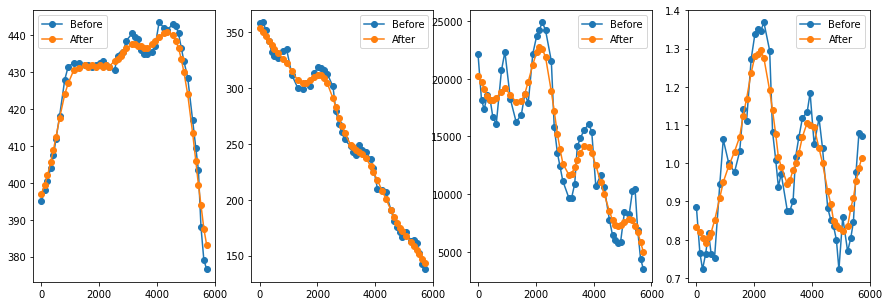

In [10]:
%matplotlib inline

fig, ax = plt.subplots(1,4, figsize=(15,5))

# X
ax[0].plot(ts_before, xysr_before.transpose()[:, 0], label="Before", marker='o')
ax[0].plot(ts_after, xysr_after.transpose()[:, 0], label="After", marker='o')

# ax[0].xlabel("Time (ms)")
# ax[0].ylabel("XYSR (pixel)")
# ax[0].title("Position vs. Time")
ax[0].legend()

# Y
ax[1].plot(ts_before, xysr_before.transpose()[:, 1], label="Before", marker='o')
ax[1].plot(ts_after, xysr_after.transpose()[:, 1], label="After", marker='o')

# ax[0].xlabel("Time (ms)")
# ax[0].ylabel("XYSR (pixel)")
# ax[0].title("Position vs. Time")
ax[1].legend()

# R
ax[2].plot(ts_before, xysr_before.transpose()[:, 2], label="Before", marker='o')
ax[2].plot(ts_after, xysr_after.transpose()[:, 2], label="After", marker='o')

# ax[0].xlabel("Time (ms)")
# ax[0].ylabel("XYSR (pixel)")
# ax[0].title("Position vs. Time")
ax[2].legend()

# S
ax[3].plot(ts_before, xysr_before.transpose()[:, 3], label="Before", marker='o')
ax[3].plot(ts_after, xysr_after.transpose()[:, 3], label="After", marker='o')

# ax[0].xlabel("Time (ms)")
# ax[0].ylabel("XYSR (pixel)")
# ax[0].title("Position vs. Time")
ax[3].legend()

plt.show()

(4, 47)


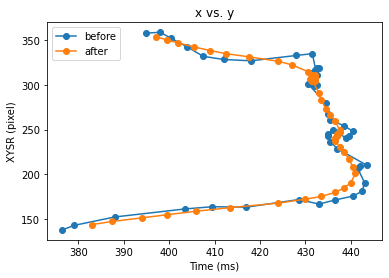

In [11]:
print(xysr_before.shape)
plt.plot(xysr_before[0, :], xysr_before[1, :], marker = 'o',label="before")
plt.plot(xysr_after[0, :], xysr_after[1, :], marker = 'o', label="after")
plt.xlabel("Time (ms)")
plt.ylabel("XYSR (pixel)")
plt.title("x vs. y")
plt.legend()